In [1]:
%%capture
# capture here to avoid printing cache details
import torch
from hr_dv2 import HighResDV2
from hr_dv2 import transform as tr
from hr_dv2.utils import do_single_pca, rescale_pca

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
# load original model for comparison
original_net = HighResDV2("dinov2_vits14_reg", stride=14, dtype=torch.float16)
# load model, specifying the original name on torch hub, the desired new stride of input layer (was 14, now 4) and dtype
net = HighResDV2("dinov2_vits14_reg", stride=4, dtype=torch.float16)
for n in [original_net, net]:
    n.cuda()
    n.eval()

Example data from ['Microstructure segmentation with deep learning encoders pre-trained on a large microscopy dataset'](https://www.nature.com/articles/s41524-022-00878-5) and its [github](https://github.com/nasa/pretrained-microscopy-models)

In [2]:
path = "repo/example.png"
_img = Image.open(path)
_h, _w = _img.height, _img.width
# we need to crop the input image to the closest multiple of the model's original patch size (14)
input_transform = tr.closest_crop(_h, _w, 14, True)
# return the transformed (cropped, normalized) tensor and (cropped) image
img_tensor, img = tr.load_image(path, input_transform)
img_arr = np.array(img)
h, w, c = img_arr.shape
# send to GPU and float16
img_tensor.to(torch.float16)
img_tensor = img_tensor.cuda()

In [3]:
# get our transforms we use to further upsample features: input shifts in 1 and 2-pixel neighbourhood
# and flip transforms
shift_dists = [i for i in range(1, 3)]
fwd_shift, inv_shift = tr.get_shift_transforms(shift_dists, 'Moore')
fwd_flip, inv_flip = tr.get_flip_transforms()
# we have to combine all permutations of flips and shifts and their inverses
fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)

net.set_transforms(fwd, inv)

In [4]:
lr_feats_tensor = original_net.forward(img_tensor)
# to cpu and numpy
lr_feats_np = tr.to_numpy(lr_feats_tensor)
lr_feats_flat = tr.flatten(lr_feats_np, lr_feats_np.shape[1], lr_feats_np.shape[2], lr_feats_np.shape[0])
# 3 dim PCA of flattened features
lr_pca = do_single_pca(lr_feats_flat, 3, n_samples=50000)

In [5]:
hr_feats_tensor = net.forward(img_tensor)
# to cpu and numpy
hr_feats_np = tr.to_numpy(hr_feats_tensor)
hr_feats_flat = tr.flatten(hr_feats_np, hr_feats_np.shape[1], hr_feats_np.shape[2], hr_feats_np.shape[0])
# 3 dim PCA of flattened features
hr_pca = do_single_pca(hr_feats_flat, 3, n_samples=50000)

In [6]:
lr_rescaled = rescale_pca(lr_pca)
hr_rescaled = rescale_pca(hr_pca)

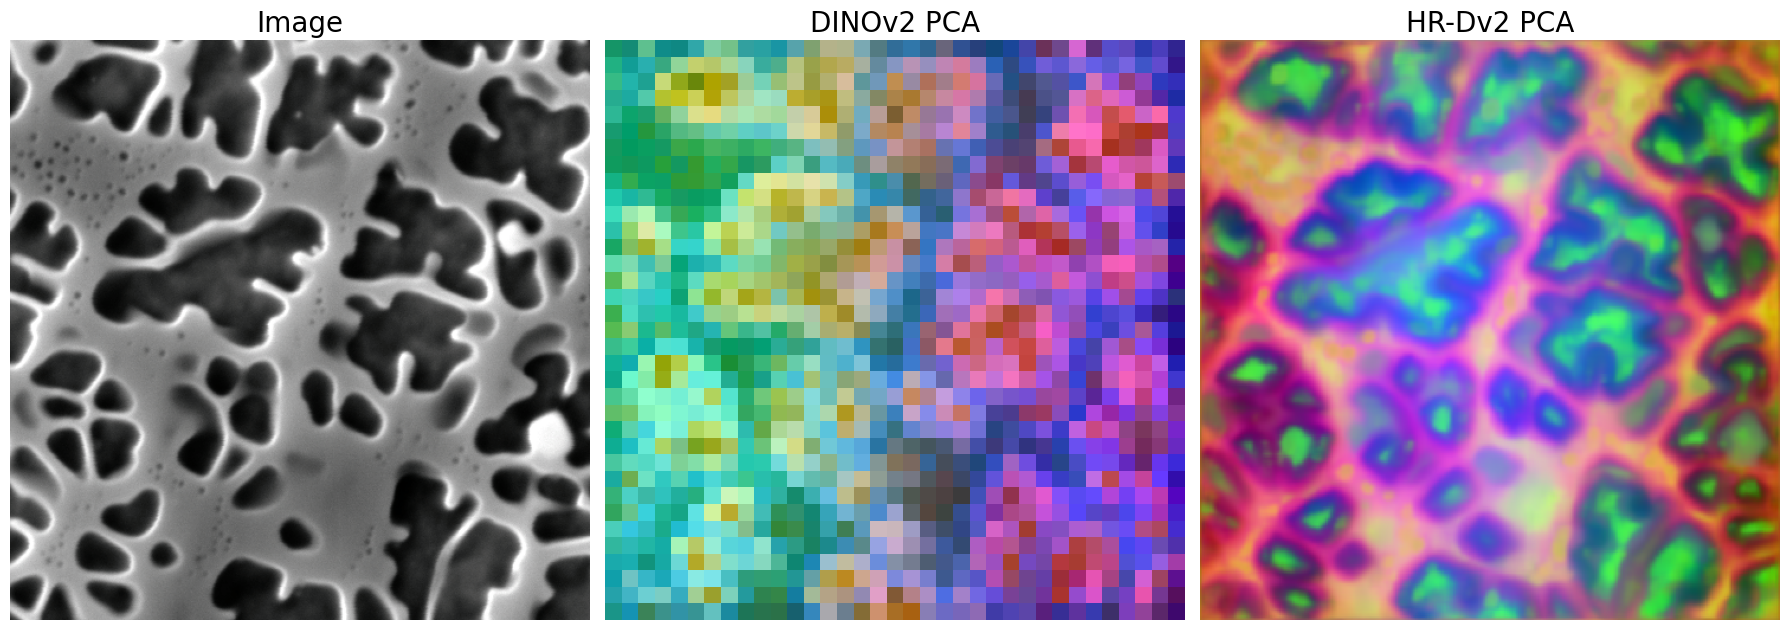

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18, 8)

axs[0].imshow(img)
axs[1].imshow(lr_rescaled.reshape(h, w, 3), interpolation='nearest')
axs[2].imshow(hr_rescaled.reshape(h, w, 3) , interpolation='nearest')

titles = ["Image", "DINOv2 PCA", "HR-Dv2 PCA"]
for i, ax in enumerate(axs):
    ax.set_axis_off()
    ax.set_title(titles[i], fontsize=20)
plt.tight_layout()